In [101]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage.filters import convolve

In [179]:
#import images
cobra = cv2.imread('cobra.jpg', 0)
road = cv2.imread('road.jpg', 0)
lady = cv2.imread('lady.jpg', 0)

Canny edge detection method:

In this notebook, I will first use openCV to demonstrate how the Canny Edge detection method works and then implement it by scratch after.


Key ideas: 
- intensity on edges much higher than the pixels around it
- we can treat it as a signals processing probem

Canny Edge Detector:

1. Noise Removal: smoothen image using Gaussian filter
2. Gradient Calculation: calculate gradient and direction of each pixel
3. Non-Maximal Suppression: pick local maxima to ensure we pick edges
4. Hystheresis Thresholding: thresholds for what is an edge



In [180]:
def cv2_canny_edge_detection(img):
    edges_detected = cv2.Canny(img, 150, 200)
    images = [img, edges_detected]
    loc = [121, 122]
    for l, edge_image in zip(loc, images):
        plt.subplot(l)
        plt.imshow(edge_image, cmap='gray')
        plt.show()

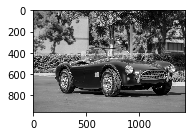

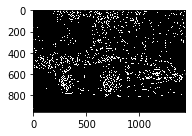

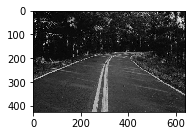

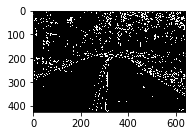

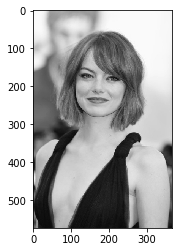

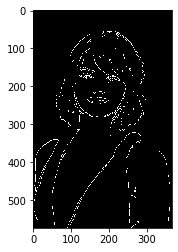

In [181]:
cv2_canny_edge_detection(cobra)
cv2_canny_edge_detection(road)
cv2_canny_edge_detection(lady)

In [206]:
def my_canny_edge_detection(img):
    def remove_noise(s = 5, std = 1):
        '''
        remove noise from image using a gaussian kernal of 
            size s and standard deviation of std
        returns a gaussian signal that we can convolve with the image
        '''
        #find k such that we can calculate:
            # (1/(2pi*std))* exp(-((i-(k+1)^2) + (j - (k+1)^2)) / (2std))
        n = int(s)//2
        x, y = np.mgrid[-n:n+1, -n:n+1]
        normal = 1/(2.0 * np.pi * std)
        g_filter = normal * np.exp(-((x**2 + y**2) / (2.0*std)))
        return g_filter
    
    def calc_gradient(img):
        '''
        approximate gradient using 
            sobel filters to find intesnities and directions
        the sobel operator is used to approximate gradients:
            convolve image with sobel operator
        '''
        #sobel operators
        kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        ky = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        
        #convlve sobel operators with image
        ix = ndimage.filters.convolve(img, kx)
        iy = ndimage.filters.convolve(img, ky)
        
        #find magnitude and direction of whole matrix
        magnitude = np.hypot(ix, iy)
        direction = np.arctan2(iy, ix)
        
        #direction in radians
        return (magnitude, direction)
    
    def non_maxima_suppression(magnitude, direction):
        #create m by n matrix initialized to 0
        m, n = magnitude.shape
        mat = np.zeros((m, n), dtype=np.int32)
        
        #convert radians to degrees and scale 0 - 180
        degrees = direction * 180/np.pi
        degrees[degrees<0] += 180
        
        #find edge direction and check if pixel has higher intensities 
            #than pixel that is being process
        for i in range(1, m-1):
            for j in range(1, n-1):
                if (i>=0 and i<m) and (j>=0 and j<n):
                    q, r = 255, 255
                    #check surroundings to find local maxima
                    
                    #0
                    if (0 <= degrees[i, j] < 22.5 or 157.5 <= degrees[i, j] <= 180):
                        q = magnitude[i, j+1]
                        r = magnitude[i, j-1]
                    #45
                    elif (22.5 <= degrees[i, j] < 67.5):
                        q = magnitude[i+1, j-1]
                        r = magnitude[i-1, j+1]
                    #90
                    elif (67.5 <= degrees[i, j] < 112.5):
                        q = magnitude[i-1, j]
                        r = magnitude[i+1, j]
                    #135
                    elif (112.5 <= degrees[i, j] < 157.5):
                        q = magnitude[i-1, j-1]
                        r = magnitude[i+1, j+1]
                        
                    if magnitude[i, j] >= q and magnitude[i, j] >= r:
                        mat[i, j] = magnitude[i, j]
        return mat
    
    def threshold(mat, low_ratio = .09, high_ratio = .17):
        '''
        identify strong weak and non-relevant pixels
        '''
        high = mat.max() * high_ratio
        low = high * low_ratio
        
        m, n = magnitude.shape
        res = np.zeros((m, n), dtype=np.int32)
        
        #intensities for strong and weak pixels
        weak = np.int32(100)
        strong = np.int32(255)
        
        #pixels that are strong, weak, or should be 0'd out
        s_i, s_j = np.where(mat >= high)
        z_i, z_j = np.where(mat<low)
        w_i, w_j = np.where((mat<=high) & (mat>=low))
        
        res[w_i, w_j] = weak
        res[s_i, s_j] = strong
        
        return (res)
    
    def hysteresis(img, weak=0, strong=255):
        '''
        transform weak pixels into string ones 
            iff the pixel around it is strong
        '''
        m, n = magnitude.shape
        res = np.zeros((m, n), dtype=np.int32)
        for i in range(1, m-1):
            for j in range(1, n-1):
                if (i>=0 and i<m) and (j>=0 and j<n):
                    if (img[i+1][j-1] == strong \
                        or img[i+1][j] == strong \
                        or img[i+1][j+1] == strong \
                        or img[i][j-1] == strong \
                        or img[i][j+1] == strong \
                        or img[i-1][j-1] == strong \
                        or img[i-1][j] == strong \
                        or img[i-1][j+1] == strong):
                        
                        #if any surrounding pixels are strong, this is strong
                        res[i, j] = strong
        return res
    
    wo_noise = convolve(img, remove_noise())
    magnitude, direction = calc_gradient(wo_noise)
    non_max = non_maxima_suppression(magnitude, direction)
    t = threshold(non_max)
    res_img = hysteresis(t)
    
    if res_img.shape[0] == 3:
        res_img = res_img.transpose(1,2,0)
    plt.subplot(1, 2, 1)
    plt.imshow(res_img, cmap='gray')
    plt.show()

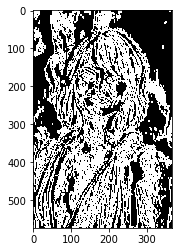

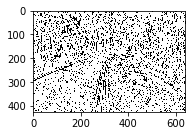

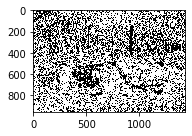

In [207]:
my_canny_edge_detection(lady)
my_canny_edge_detection(road)
my_canny_edge_detection(cobra)

Credits:

https://towardsdatascience.com/simple-edge-detection-model-using-python-91bf6cf00864

https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123